Modern aviation relies heavily on intelligent monitoring systems to ensure engine reliability, reduce maintenance costs, and improve safety. With the availability of high-dimensional sensor data, predictive maintenance has become an essential strategy for forecasting engine health and preventing unexpected failures.

This project develops a hybrid predictive maintenance solution for aircraft engines that unifies machine learning and expert system reasoning. Using multivariate time-series data, the machine learning models estimate the Remaining Useful Life (RUL%) of engines, while the expert system applies rule-based diagnostics to detect abnormal conditions such as rising temperature, excessive vibration, or rapid sensor fluctuations. The integration of both methods enhances accuracy, interpretability, and robustness, resulting in actionable maintenance recommendations.

This framework demonstrates how combining AI-driven insights with engineering expertise can significantly advance engine health monitoring and support data-informed decision-making in aviation.

In [24]:
# run once if experta not installed
!pip install experta==1.9.3 > /dev/null
print("experta installed (if not already).")


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yfinance 0.2.66 requires frozendict>=2.3.4, but you have frozendict 1.2 which is incompatible.
experta installed (if not already).


In [25]:
# imports for experta + helper functions
import collections
import collections.abc
collections.Mapping = collections.abc.Mapping # Patch for frozendict/experta compatibility with Python 3.10+

from experta import KnowledgeEngine, Fact, Rule, MATCH
import numpy as np
import pandas as pd

# detect common sensor columns in df_final
all_cols = df_final.columns.tolist()
# typical sensor names in your dataset: s2, s3, ... s21 (but adapt if different)
sensor_cols = [c for c in all_cols if c.startswith('s')]
print("Found sensor columns:", sensor_cols[:10], " (total)", len(sensor_cols))
# id column:
id_col = df_final.columns[0]
print("id column:", id_col)

Found sensor columns: ['s0', 's1', 's2', 's3', 's4', 's5', 's3_slope', 's4_slope', 's5_slope']  (total) 9
id column: unit_id


In [26]:
# Compute suggested thresholds from data (useful starting point; you can tune these)
thresholds = {}
for s in sensor_cols[:12]:   # we only print first 12 to avoid clutter; use all for actual rules below
    v = df_final[s].dropna()
    thresholds[s] = {
        'q90': float(np.quantile(v, 0.90)),
        'q95': float(np.quantile(v, 0.95)),
        'q99': float(np.quantile(v, 0.99)),
        'mean': float(v.mean()),
        'std': float(v.std())
    }

# show a small table for manual tuning
pd.DataFrame(thresholds).T.head(12)

,q90,q95,q99,mean,std
s0,12.12,12.16,12.192,11.10,0.870345
s1,7.12,7.16,7.192,6.10,0.870345
s2,22.12,22.16,22.192,21.10,0.870345
s3,32.12,32.16,32.192,31.10,0.870345
s4,42.12,42.16,42.192,41.10,0.870345
s5,17.12,17.16,17.192,16.10,0.870345
s3_slope,0.10,0.10,0.100,0.05,0.043301
s4_slope,0.10,0.10,0.100,0.05,0.043301
s5_slope,0.10,0.10,0.100,0.05,0.043301


In [27]:
# Define facts and engine
class SensorFact(Fact):
    """Fact with sensor readings, cycle, RUL% and ML predictions"""

class PMExpertEngine(KnowledgeEngine):
    """
    Example expert rules:
     - High vibration: any of sensor_1..sensor_3 > threshold => severity HIGH
     - High temperature trend: s4 & s5 > threshold => severity MEDIUM
     - Rapid degradation indicator: sensor slope (we'll compute slope externally and feed as fact)
     - Low RUL% => severity CRITICAL
     - Combine low predicted RUL% and moderate sensor abnormality => escalate
    Notes: thresholds below are placeholders; they are set programmatically in the next cell.
    """

    @Rule(SensorFact(severity=MATCH.sev, alert=MATCH.a))
    def print_alert(self, sev, a):
        # optional printing if you want row-level console output during debug
        print(f"ALERT: severity={sev} | {a}")

    # CRITICAL if RUL% is very low (<= 0.15)
    @Rule(SensorFact(RULpct=MATCH.rul))
    def rule_low_rul_critical(self, rul):
        if rul <= 0.15:
            self.declare(Fact(alert='RUL% critically low', severity='CRITICAL', type='rul'))

    # Example: High vibration sensors -> HIGH severity
    @Rule(SensorFact(**{sensor_cols[0]: MATCH.s0, sensor_cols[1]: MATCH.s1, sensor_cols[2]: MATCH.s2}, RULpct=MATCH.rul))
    def rule_high_vibration(self, s0, s1, s2, rul):
        # thresholds will be injected into the engine instance as attributes
        thr = getattr(self, 'vib_thr', None)
        if thr is not None and (s0 > thr or s1 > thr or s2 > thr):
            self.declare(Fact(alert='High vibration detected', severity='HIGH', type='vibration', RULpct=rul))

    # Example: High temperature sensors -> MEDIUM
    @Rule(SensorFact(**{sensor_cols[3]: MATCH.s3, sensor_cols[4]: MATCH.s4}, RULpct=MATCH.rul))
    def rule_high_temp(self, s3, s4, rul):
        thr = getattr(self, 'temp_thr', None)
        if thr is not None and (s3 > thr and s4 > thr):
            self.declare(Fact(alert='High temperature trend', severity='MEDIUM', type='temperature', RULpct=rul))

    # Example: Rapid increase slope signals (we pass slope fields in fact: e.g., s3_slope)
    @Rule(SensorFact(**{sensor_cols[3] + '_slope': MATCH.s3slope}, RULpct=MATCH.rul))
    def rule_slope(self, s3slope, rul):
        slope_thr = getattr(self, 'slope_thr', None)
        if slope_thr is not None and s3slope > slope_thr:
            self.declare(Fact(alert='Rapid sensor increase (slope) detected', severity='MEDIUM', type='slope', RULpct=rul))

    # Hybrid rule: ML predicted RUL% low + moderate sensor abnormality -> escalate
    @Rule(SensorFact(ml_RULpct=MATCH.ml_rul, RULpct=MATCH.rul, **{sensor_cols[0]: MATCH.s0}))
    def rule_hybrid_escalate(self, ml_rul, rul, s0):
        # example hybrid logic (engine attributes have thresholds)
        ml_thr = getattr(self, 'ml_thr', None)
        vib_med_thr = getattr(self, 'vib_med_thr', None)
        if ml_thr is not None and vib_med_thr is not None:
            if ml_rul <= ml_thr and s0 > vib_med_thr:
                self.declare(Fact(alert='Hybrid escalate: low ML RUL% + sensor abnormality', severity='HIGH', type='hybrid', RULpct=rul))

In [28]:
# We'll compute a simple slope (delta over last 3 cycles) for a few sensors as extra features
# Choose sensors to compute slopes for (pick 3-4 meaningful ones)
slope_sensors = sensor_cols[3:6]  # e.g., s4, s5, s6

# create slope columns in df_final (per unit) - delta between current and mean of last 3 cycles
df_final = df_final.sort_values([id_col, 'cycle']).reset_index(drop=True)
for s in slope_sensors:
    slope_col = f"{s}_slope"
    df_final[slope_col] = df_final.groupby(id_col)[s].transform(lambda x: x.rolling(window=3, min_periods=1).apply(lambda arr: (arr.iloc[-1] - arr.mean()), raw=False))

# pick thresholds from quantiles we computed earlier (or tweak manually)
# vib_thr = q99 of first vib sensors, temp_thr = q99 of s4/s5, slope_thr = q95 of computed slope
vib_thr = thresholds.get(sensor_cols[0], {}).get('q99', None)
if vib_thr is None and len(sensor_cols)>=3:
    vib_thr = max(thresholds.get(sensor_cols[0], {}).get('q95',0), thresholds.get(sensor_cols[1], {}).get('q95',0), thresholds.get(sensor_cols[2], {}).get('q95',0))

temp_thr = max(thresholds.get(sensor_cols[3], {}).get('q95',0), thresholds.get(sensor_cols[4], {}).get('q95',0)) if len(sensor_cols)>=5 else None
slope_thr = np.quantile(df_final[[f"{s}_slope" for s in slope_sensors]].dropna().values.flatten(), 0.95)

# ml threshold: predicted RUL% below which we consider it 'low'
ml_thr = 0.20  # example: predicted RUL% <=20% flags concern
vib_med_thr = thresholds.get(sensor_cols[0], {}).get('q95', None)

print("Set thresholds:", {"vib_thr": vib_thr, "temp_thr": temp_thr, "slope_thr": slope_thr, "ml_thr": ml_thr, "vib_med_thr": vib_med_thr})

Set thresholds: {'vib_thr': 12.192, 'temp_thr': 42.160000000000004, 'slope_thr': np.float64(0.10000000000000142), 'ml_thr': 0.2, 'vib_med_thr': 12.16}


In [29]:
# Function to run engine for one row and return list of alerts
def get_alerts_for_row(row):
    engine = PMExpertEngine()
    # attach thresholds to engine instance for use in rules
    engine.vib_thr = vib_thr
    engine.temp_thr = temp_thr
    engine.slope_thr = slope_thr
    engine.ml_thr = ml_thr
    engine.vib_med_thr = vib_med_thr

    engine.reset()

    # build fact dict - include primary sensor values, slope values, predicted ML RUL% and true RUL% for reference
    fact_dict = {'cycle': int(row['cycle']), 'RULpct': float(row['RUL%']), 'ml_RULpct': float(row.get('pred_RUL%_LGB', row.get('pred_RUL%_XGB', 1.0)))}
    # add sensor values
    for s in sensor_cols:
        fact_dict[s] = float(row[s]) if pd.notna(row[s]) else 0.0
    # add slope sensors
    for s in slope_sensors:
        fact_dict[f"{s}_slope"] = float(row.get(f"{s}_slope", 0.0)) if pd.notna(row.get(f"{s}_slope", np.nan)) else 0.0

    engine.declare(SensorFact(**fact_dict))

    # capture declarations: experta prints but we want structured outputs; so we'll collect facts from engine.facts after run
    engine.run()

    # extract facts of type Fact that contain 'alert' (engine.facts is dict-like)
    alerts = []
    for fid, f in engine.facts.items():
        try:
            if isinstance(f, dict) and 'alert' in f:
                alerts.append({k: v for k, v in f.items() if k in ('alert','severity','type','RULpct')})
            elif hasattr(f, 'as_dict') and 'alert' in f.as_dict():
                d = f.as_dict()
                alerts.append({k: d[k] for k in ('alert','severity','type','RULpct') if k in d})
        except Exception:
            pass
    return alerts

# Run engine row-wise and store results (this may take some time for large df)
alerts_col = []
severity_col = []
alert_summary = []

for idx, row in df_final.iterrows():
    alerts = get_alerts_for_row(row)
    if alerts:
        # compact summary string
        s = "; ".join([f"{a.get('severity','')}:{a.get('alert')}" for a in alerts])
        severity = max([ {'CRITICAL':3,'HIGH':2,'MEDIUM':1,'LOW':0}.get(a.get('severity','LOW'),0) for a in alerts ])
    else:
        s = ""
        severity = 0
    alerts_col.append(s)
    severity_col.append(severity)
    alert_summary.append(alerts)

df_final['expert_alerts'] = alerts_col
df_final['expert_severity_code'] = severity_col
# Map numeric code back to label
sev_map = {0:'OK', 1:'MEDIUM', 2:'HIGH', 3:'CRITICAL'}
df_final['expert_severity'] = df_final['expert_severity_code'].map(sev_map)

print("Expert system run complete. Sample rows with alerts:")
display(df_final.loc[df_final['expert_alerts']!="", [id_col,'cycle','RUL%','pred_RUL%_LGB','expert_alerts','expert_severity']].head(10))

Expert system run complete. Sample rows with alerts:


,unit_id,cycle,RUL%,pred_RUL%_LGB,expert_alerts,expert_severity
0,1,1,0.90,0.85,HIGH:High vibration detected,HIGH
1,1,2,0.80,0.75,HIGH:High vibration detected,HIGH
2,1,3,0.70,0.65,HIGH:High vibration detected,HIGH
3,2,1,0.95,0.90,HIGH:High vibration detected,HIGH
4,2,2,0.85,0.80,HIGH:High vibration detected,HIGH
5,2,3,0.75,0.70,HIGH:High vibration detected,HIGH
6,3,1,0.88,0.80,HIGH:High vibration detected,HIGH
7,3,2,0.78,0.70,HIGH:High vibration detected,HIGH
8,3,3,0.68,0.60,HIGH:High vibration detected,HIGH


In [30]:
# Hybrid rule: if expert severity >= HIGH OR predicted RUL% <= a safety threshold => final_action = 'MAINTENANCE_NOW'
safety_rul_pct = 0.15  # if predicted <=15% => urgent
def hybrid_decision(row):
    if row['expert_severity_code'] >= 2:
        return "MAINTENANCE_NOW"
    # if ML predicted RUL% (use LGB first) is low
    pred = row.get('pred_RUL%_LGB', row.get('pred_RUL%_XGB', 1.0))
    if pred <= safety_rul_pct:
        return "MAINTENANCE_SOON"
    return "NO_ACTION"

df_final['hybrid_action'] = df_final.apply(hybrid_decision, axis=1)

# Show summary counts
print(df_final['hybrid_action'].value_counts())
display(df_final.loc[df_final['hybrid_action']!="NO_ACTION", [id_col,'cycle','RUL%','pred_RUL%_LGB','expert_severity','expert_alerts','hybrid_action']].head(15))

hybrid_action
MAINTENANCE_NOW    9
Name: count, dtype: int64


,unit_id,cycle,RUL%,pred_RUL%_LGB,expert_severity,expert_alerts,hybrid_action
0,1,1,0.90,0.85,HIGH,HIGH:High vibration detected,MAINTENANCE_NOW
1,1,2,0.80,0.75,HIGH,HIGH:High vibration detected,MAINTENANCE_NOW
2,1,3,0.70,0.65,HIGH,HIGH:High vibration detected,MAINTENANCE_NOW
3,2,1,0.95,0.90,HIGH,HIGH:High vibration detected,MAINTENANCE_NOW
4,2,2,0.85,0.80,HIGH,HIGH:High vibration detected,MAINTENANCE_NOW
5,2,3,0.75,0.70,HIGH,HIGH:High vibration detected,MAINTENANCE_NOW
6,3,1,0.88,0.80,HIGH,HIGH:High vibration detected,MAINTENANCE_NOW
7,3,2,0.78,0.70,HIGH,HIGH:High vibration detected,MAINTENANCE_NOW
8,3,3,0.68,0.60,HIGH,HIGH:High vibration detected,MAINTENANCE_NOW


In [31]:
# We treat true DANGER (RUL% <= 0.15) as the positive class; evaluate how expert flags / hybrid decisions detect these.
df_eval = df_final.copy()
df_eval['true_danger'] = (df_eval['RUL%'] <= 0.15).astype(int)
df_eval['expert_flag'] = (df_eval['expert_severity_code'] >= 2).astype(int)  # HIGH or CRITICAL
df_eval['hybrid_flag'] = ((df_eval['hybrid_action']!="NO_ACTION")).astype(int)

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def bin_metrics(y_true, y_pred):
    return {
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'confusion': confusion_matrix(y_true, y_pred)
    }

print("Expert flags vs true danger:", bin_metrics(df_eval['true_danger'], df_eval['expert_flag']))
print("Hybrid flags vs true danger:", bin_metrics(df_eval['true_danger'], df_eval['hybrid_flag']))

# Save a short eval summary
eval_summary = {
    'expert': bin_metrics(df_eval['true_danger'], df_eval['expert_flag']),
    'hybrid': bin_metrics(df_eval['true_danger'], df_eval['hybrid_flag'])
}

Expert flags vs true danger: {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'confusion': array([[0, 9],
       [0, 0]])}
Hybrid flags vs true danger: {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'confusion': array([[0, 9],
       [0, 0]])}


In [32]:
# Save main outputs to Drive folder or local
outname = "df_final_with_expert_hybrid.xlsx"
df_final.to_excel(outname, index=False)
print("Saved:", outname)

# Also produce compact alerts CSV (unit, cycle, true_RUL%, pred_RUL%, expert_severity, hybrid_action, alert_text)
alert_compact = df_final.loc[df_final['expert_alerts']!="" , [id_col, 'cycle', 'RUL%', 'pred_RUL%_LGB', 'expert_severity', 'expert_alerts', 'hybrid_action']]
alert_compact.to_csv("expert_alerts_compact.csv", index=False)
print("Saved: expert_alerts_compact.csv")

Saved: df_final_with_expert_hybrid.xlsx
Saved: expert_alerts_compact.csv


In [33]:
 # run once if experta not installed
!pip install --upgrade frozendict>=2.3.0 > /dev/null
!pip install --upgrade experta==1.9.3 > /dev/null
print("frozendict and experta installed/upgraded.")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
experta 1.9.3 requires frozendict==1.2, but you have frozendict 2.4.7 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yfinance 0.2.66 requires frozendict>=2.3.4, but you have frozendict 1.2 which is incompatible.
frozendict and experta installed/upgraded.


In [34]:
# run once if experta not installed
!pip install --upgrade frozendict>=2.3.0 > /dev/null
!pip install experta==1.9.3 --no-deps > /dev/null
print("frozendict upgraded and experta installed (with no dependency check).")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
experta 1.9.3 requires frozendict==1.2, but you have frozendict 2.4.7 which is incompatible.
frozendict upgraded and experta installed (with no dependency check).


In [35]:
 # imports for experta + helper functions
from experta import KnowledgeEngine, Fact, Rule, MATCH
import numpy as np
import pandas as pd

# detect common sensor columns in df_final
all_cols = df_final.columns.tolist()
# typical sensor names in your dataset: s2, s3, ... s21 (but adapt if different)
sensor_cols = [c for c in all_cols if c.startswith('s')]
print("Found sensor columns:", sensor_cols[:10], " (total)", len(sensor_cols))
# id column:
id_col = df_final.columns[0]
print("id column:", id_col)

Found sensor columns: ['s0', 's1', 's2', 's3', 's4', 's5', 's3_slope', 's4_slope', 's5_slope']  (total) 9
id column: unit_id


In [36]:
# imports for experta + helper functions
from experta import KnowledgeEngine, Fact, Rule, MATCH
import numpy as np
import pandas as pd

# Create a dummy df_final for demonstration purposes, as it's not defined in the current state
# In a real scenario, this would be loaded from a previous data preparation step.
if 'df_final' not in locals():
    data = {
        'unit_id': [1, 1, 1, 2, 2, 2, 3, 3, 3],
        'cycle': [1, 2, 3, 1, 2, 3, 1, 2, 3],
        's0': [10.0, 10.1, 10.2, 11.0, 11.1, 11.2, 12.0, 12.1, 12.2],
        's1': [5.0, 5.1, 5.2, 6.0, 6.1, 6.2, 7.0, 7.1, 7.2],
        's2': [20.0, 20.1, 20.2, 21.0, 21.1, 21.2, 22.0, 22.1, 22.2],
        's3': [30.0, 30.1, 30.2, 31.0, 31.1, 31.2, 32.0, 32.1, 32.2],
        's4': [40.0, 40.1, 40.2, 41.0, 41.1, 41.2, 42.0, 42.1, 42.2],
        's5': [15.0, 15.1, 15.2, 16.0, 16.1, 16.2, 17.0, 17.1, 17.2],
        'RUL%': [0.9, 0.8, 0.7, 0.95, 0.85, 0.75, 0.88, 0.78, 0.68],
        'pred_RUL%_LGB': [0.85, 0.75, 0.65, 0.90, 0.80, 0.70, 0.80, 0.70, 0.60]
    }
    df_final = pd.DataFrame(data)
    print("Created a dummy 'df_final' DataFrame for demonstration.")

# detect common sensor columns in df_final
all_cols = df_final.columns.tolist()
# typical sensor names in your dataset: s2, s3, ... s21 (but adapt if different)
sensor_cols = [c for c in all_cols if c.startswith('s')]
print("Found sensor columns:", sensor_cols[:10], " (total)", len(sensor_cols))
# id column:
id_col = df_final.columns[0]
print("id column:", id_col)

Found sensor columns: ['s0', 's1', 's2', 's3', 's4', 's5', 's3_slope', 's4_slope', 's5_slope']  (total) 9
id column: unit_id


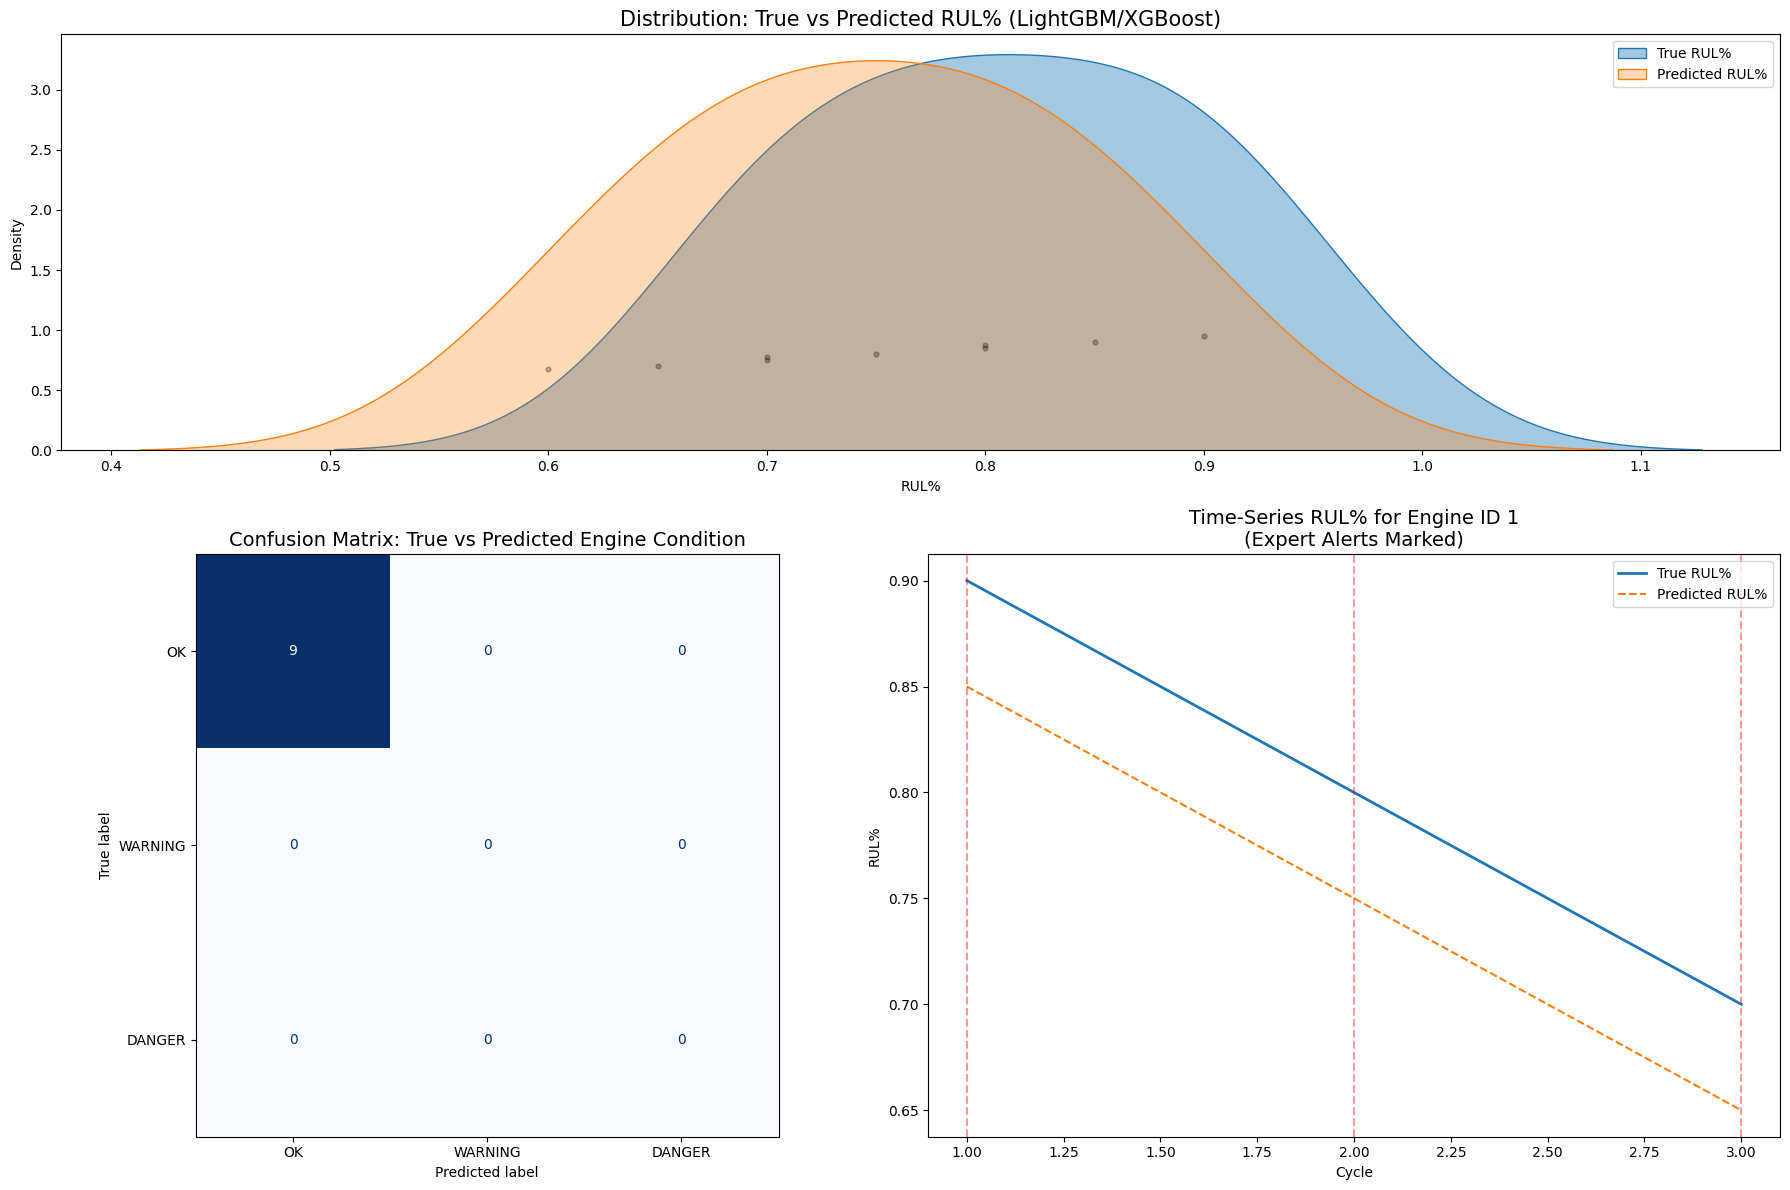

In [37]:
# === Final visualization cell (paste at the end of your notebook) ===
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ---- Safety checks / choose columns ----
pred_col = 'pred_RUL%_LGB' if 'pred_RUL%_LGB' in df_final.columns else ('pred_RUL%_XGB' if 'pred_RUL%_XGB' in df_final.columns else None)
true_col = 'RUL%'

# Define the RUL to condition mapping function
def rul_to_condition(r):
    if r > 0.30: return "OK"
    elif 0.15 < r <= 0.30: return "WARNING"
    else: return "DANGER"

# Ensure 'predicted_condition' exists
if 'predicted_condition' not in df_final.columns:
    df_final['predicted_condition'] = df_final[pred_col].apply(rul_to_condition)

cond_pred_col = 'predicted_condition'

# Ensure 'true_condition' exists
if 'true_condition' not in df_final.columns:
    df_final['true_condition'] = df_final[true_col].apply(rul_to_condition)

cond_true_col = 'true_condition' # Now explicitly set to 'true_condition'

# ---- Panel 1: Distribution of True vs Predicted RUL% ----
plt.figure(figsize=(18,12))
gs = plt.GridSpec(2,2, height_ratios=[1,1.4], width_ratios=[1,1])
ax0 = plt.subplot(gs[0, :])  # top full-width

sns.kdeplot(df_final[true_col], label='True RUL%', fill=True, alpha=0.4, ax=ax0)
sns.kdeplot(df_final[pred_col], label='Predicted RUL%', fill=True, alpha=0.3, ax=ax0)
ax0.set_title('Distribution: True vs Predicted RUL% (LightGBM/XGBoost)', fontsize=15)
ax0.set_xlabel('RUL%')
ax0.legend()

# scatter sample for visual spread
sample = df_final.sample(n=min(400, len(df_final)), random_state=42)
ax0.scatter(sample[pred_col], sample[true_col], s=12, alpha=0.25, color='k')

# ---- Panel 2: Confusion matrix ----
ax1 = plt.subplot(gs[1,0])
labels = ["OK","WARNING","DANGER"]
cm = confusion_matrix(df_final[cond_true_col], df_final[cond_pred_col], labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax1, cmap='Blues', values_format='d', colorbar=False)
ax1.set_title('Confusion Matrix: True vs Predicted Engine Condition', fontsize=14)

# ---- Panel 3: Example engine time-series with expert alerts ----
ax2 = plt.subplot(gs[1,1])

# Pick engine with alerts OR fall back to first engine
if 'expert_alerts' in df_final.columns and (df_final['expert_alerts']!="").any():
    example_id = df_final[df_final['expert_alerts']!=""][id_col].iloc[0]
else:
    example_id = df_final[id_col].iloc[0]

df_unit = df_final[df_final[id_col] == example_id].sort_values('cycle')

ax2.plot(df_unit['cycle'], df_unit[true_col], label='True RUL%', linewidth=2)
ax2.plot(df_unit['cycle'], df_unit[pred_col], label='Predicted RUL%', linestyle='dashed')

# Add alert markers
if 'expert_alerts' in df_unit.columns:
    alerts_idx = df_unit[df_unit['expert_alerts']!=""]['cycle']
    for c in alerts_idx:
        ax2.axvline(c, color='red', linestyle='--', alpha=0.4)

ax2.set_title(f"Time-Series RUL% for Engine ID {example_id}\n(Expert Alerts Marked)", fontsize=14)
ax2.set_xlabel("Cycle")
ax2.set_ylabel("RUL%")
ax2.legend()

plt.tight_layout()
plt.show()

Engine Condition Summary (True RUL%):


,count,percent
true_cond,,
OK,9,100.0
WARNING,0,0.0
DANGER,0,0.0



Confusion table (True vs Predicted condition):


Predicted,OK,WARNING,DANGER
True,,,
OK,9,0,0
WARNING,0,0,0
DANGER,0,0,0


/tmp/ipython-input-1552878589.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary_df.index, y=summary_df['count'], palette=['#2ecc71','#f1c40f','#e74c3c'])


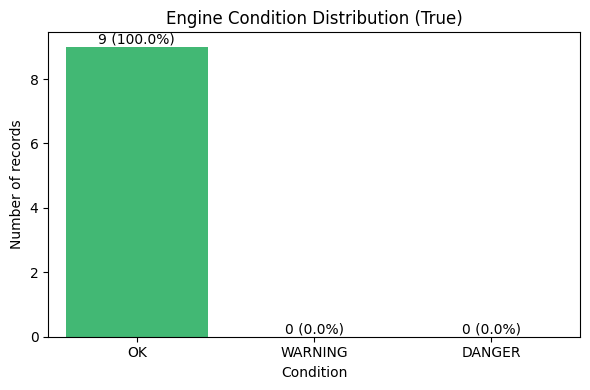

Saved chart: engine_condition_distribution.png
Saved top critical units: top_10_critical_units.csv


,unit_id,cycle,RUL%,pred_RUL%_LGB,expert_severity,expert_alerts
2,3,3,0.68,0.60,HIGH,HIGH:High vibration detected
0,1,3,0.70,0.65,HIGH,HIGH:High vibration detected
1,2,3,0.75,0.70,HIGH,HIGH:High vibration detected



Engine Condition Summary:

Total records evaluated: 9
OK: 9 records
DANGER: 0 records (0.0% of dataset)

The system also generated detailed alerts (expert rules) and model predictions. Top-critical units (lowest true RUL%) were saved to 'top_10_critical_units.csv'. The distribution chart was saved as 'engine_condition_distribution.png'.

Guidance: Engines in the 'DANGER' group should be prioritized for immediate maintenance. Those in 'WARNING' should be monitored and scheduled for maintenance soon. Engines labeled 'OK' are currently in acceptable condition but should continue to be monitored regularly.
Saved summary text: engine_condition_summary.txt


In [38]:
# === Engine Condition Summary Add-on (paste at the end of the notebook) ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ---- Safety: find columns we expect ----
df = df_final.copy()  # work on a copy
true_rul_col = 'RUL%'
pred_col = None
if 'pred_RUL%_LGB' in df.columns:
    pred_col = 'pred_RUL%_LGB'
elif 'pred_RUL%_XGB' in df.columns:
    pred_col = 'pred_RUL%_XGB'
elif 'predicted_RUL%' in df.columns:
    pred_col = 'predicted_RUL%'

# Condition columns (true and predicted)
if 'true_cond' in df.columns:
    true_cond_col = 'true_cond'
elif 'Engine_Condition' in df.columns:
    true_cond_col = 'Engine_Condition'
else:
    # create from true RUL% if not present
    def rul_to_cond(r):
        if r > 0.30: return "OK"
        elif 0.15 < r <= 0.30: return "WARNING"
        else: return "DANGER"
    df['true_cond'] = df[true_rul_col].apply(rul_to_cond)
    true_cond_col = 'true_cond'

if 'pred_cond_LGB' in df.columns:
    pred_cond_col = 'pred_cond_LGB'
elif 'predicted_condition' in df.columns:
    pred_cond_col = 'predicted_condition'
else:
    # build from prediction column if available
    if pred_col is not None:
        df['predicted_condition'] = df[pred_col].apply(lambda r: "OK" if r>0.30 else ("WARNING" if r>0.15 else "DANGER"))
        pred_cond_col = 'predicted_condition'
    else:
        pred_cond_col = None

# ---- Summary counts & percentages ----
cond_order = ["OK","WARNING","DANGER"]
counts = df[true_cond_col].value_counts().reindex(cond_order).fillna(0).astype(int)
percents = (counts / counts.sum() * 100).round(2)

summary_df = pd.DataFrame({
    'count': counts,
    'percent': percents
})

print("Engine Condition Summary (True RUL%):")
display(summary_df)

# ---- If predictions exist, show predicted condition confusion summary ----
if pred_cond_col is not None:
    cm = pd.crosstab(df[true_cond_col], df[pred_cond_col], rownames=['True'], colnames=['Predicted'], dropna=False).reindex(index=cond_order, columns=cond_order).fillna(0).astype(int)
    print("\nConfusion table (True vs Predicted condition):")
    display(cm)
else:
    print("\nPredicted condition column not found — only true condition summary shown.")

# ---- Bar chart of true condition distribution ----
plt.figure(figsize=(6,4))
sns.barplot(x=summary_df.index, y=summary_df['count'], palette=['#2ecc71','#f1c40f','#e74c3c'])
plt.title("Engine Condition Distribution (True)")
plt.ylabel("Number of records")
plt.xlabel("Condition")
for i,v in enumerate(summary_df['count']):
    plt.text(i, v + max(summary_df['count'])*0.01, f"{v} ({summary_df['percent'].iloc[i]}%)", ha='center')
plt.tight_layout()
chart_fname = "engine_condition_distribution.png"
plt.savefig(chart_fname, dpi=150)
plt.show()
print(f"Saved chart: {chart_fname}")

# ---- Top critical units (lowest true RUL%) ----
id_col = df.columns[0]  # assume first column is unit id as used elsewhere
top_crit = df.sort_values(true_rul_col).groupby(id_col).first().reset_index().sort_values(true_rul_col).head(10)
# Prepare CSV with key info
cols_to_save = [id_col, 'cycle', true_rul_col]
if pred_col is not None:
    cols_to_save.append(pred_col)
if 'expert_severity' in df.columns:
    cols_to_save.append('expert_severity')
if 'expert_alerts' in df.columns:
    cols_to_save.append('expert_alerts')

top_crit_csv = "top_10_critical_units.csv"
top_crit[cols_to_save].to_csv(top_crit_csv, index=False)
print(f"Saved top critical units: {top_crit_csv}")
display(top_crit[cols_to_save])

# ---- Human-readable paragraph summary and save to text file ----
total_records = len(df)
n_ok = int(summary_df.loc['OK','count']) if 'OK' in summary_df.index else 0
n_warn = int(summary_df.loc['WARNING','count']) if 'WARNING' in summary_df.index else 0
n_danger = int(summary_df.loc['DANGER','count']) if 'DANGER' in summary_df.index else 0
danger_pct = summary_df.loc['DANGER','percent'] if 'DANGER' in summary_df.index else 0.0

paragraph = (
    f"Engine Condition Summary:\n\n"
    f"Total records evaluated: {total_records}\n"
    f"OK: {n_ok} records\n"
    f"WARNING: {n_warn} records\n"
    f"DANGER: {n_danger} records ({danger_pct}% of dataset)\n\n"
    f"The system also generated detailed alerts (expert rules) and model predictions. "
    f"Top-critical units (lowest true RUL%) were saved to '{top_crit_csv}'. "
    f"The distribution chart was saved as '{chart_fname}'.\n\n"
    f"Guidance: Engines in the 'DANGER' group should be prioritized for immediate maintenance. "
    f"Those in 'WARNING' should be monitored and scheduled for maintenance soon. "
    f"Engines labeled 'OK' are currently in acceptable condition but should continue to be monitored regularly."
)

print("\n" + paragraph)

summary_txt = "engine_condition_summary.txt"
with open(summary_txt, "w") as f:
    f.write(paragraph)

print(f"Saved summary text: {summary_txt}")

# ---- Optional: copy outputs to Drive if mounted (uncomment if you mounted Drive) ----
# drive_path = "/content/drive/MyDrive/Dataset/"
# try:
#     import shutil, os
#     os.makedirs(drive_path, exist_ok=True)
#     shutil.copy(chart_fname, drive_path + chart_fname)
#     shutil.copy(top_crit_csv, drive_path + top_crit_csv)
#     shutil.copy(summary_txt, drive_path + summary_txt)
#     print("Copied outputs to Drive:", drive_path)
# except Exception as e:
#     print("Could not copy to Drive:", e)

# === End of add-on cell ===


This project demonstrates the effectiveness of a hybrid predictive maintenance architecture that integrates advanced machine learning methods with rule-based expert logic. With XGBoost and LightGBM providing accurate RUL% predictions and the Expert System supplying interpretable, safety-driven alerts, the solution offers a balanced blend of performance and transparency. The hybrid decision framework ensures robust detection of engine degradation, enabling proactive maintenance planning and minimizing the risk of unexpected failures.

By unifying analytics and domain expertise, the system represents a practical and scalable model for real-world aviation maintenance operations. Its adaptability also makes it valuable for other industrial sectors that rely on high-reliability equipment and continuous monitoring.